In [2]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
data_path = "exercise_wu/ex5data1.mat"

#Method 1

data = sio.loadmat(data_path)
print(type(data))

data_label = data.keys()
print(list(data_label))

# data_data = data.values()
# data_data = list(data_data)
# print(pd.DataFrame(data_data).head())
# data_label = data.get('label')#取出字典里的label

# data_data = data.get('data')#取出字典里的data

# print(data_label)
# print(type(data_data))
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('exercise_wu/ex5data1.mat')
    # map根据提供的函数对指定序列做映射
    # raval和flatten都是将数据扁平化
    # flatten不会改变原数据
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

<class 'dict'>
['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval']


In [77]:
X, y, Xval, yval, Xtest, ytest = load_data()
# print('Xval:', Xval)
# print('Xtest:', Xtest)

In [78]:
df = pd.DataFrame({'water_level':X, 'flow':y})

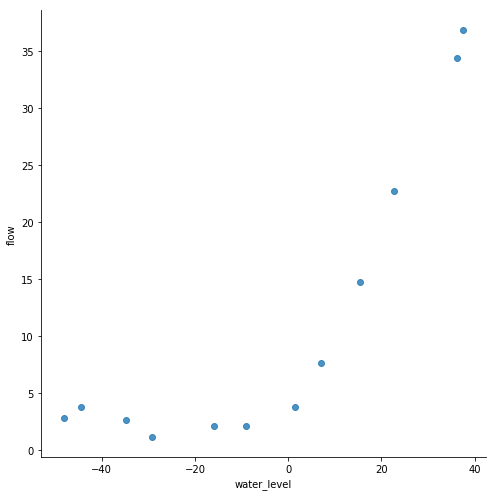

In [79]:
sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [80]:
# 给x xval xtest均加入一列，首列为1
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [81]:
# 计算代价函数
def cost(theta, X, y):
    m = X.shape[0]
    inner = X @ theta - y
    square = inner.T @ inner
    cost = square/(2*m)
    
    return cost

In [82]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

In [83]:
def gradient(theta, X, y):
    m = X.shape[0]
    inner = X.T @ (X @ theta - y)
    return inner / m

In [84]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

In [85]:
# 加入正则化项的梯度
def regularized_gradient(theta, X, y, lmda):
    m = X.shape[0]
    regula_theta = theta.copy()
    regula_theta[0] = 0
    regula_theta = (lmda / m)*regula_theta
    
    return gradient(theta, X, y) + regula_theta

In [86]:
lmda = 1
regularized_gradient(theta, X, y, lmda)

array([-15.30301567, 598.25074417])

In [87]:
def linear_regression_np(X, y, l):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [88]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [89]:
theta = np.ones(X.shape[0])
l = 0
print(linear_regression_np(X, y, l))

final_theta = linear_regression_np(X, y, l).get('x')

     fun: 22.373906495108923
     jac: array([ 1.12329844e-07, -4.11893619e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 9
     nit: 4
  status: 1
 success: True
       x: array([13.08790362,  0.36777923])


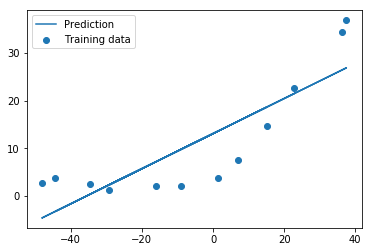

In [90]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [91]:
training_cost, cv_cost = [], []

In [92]:
m = X.shape[0]
print(m)
# m是训练集的行数，交叉验证集要计算全量
for i in range(1, m+1):
#     print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
#     print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    # print(training_cost)
    cv_cost.append(cv)
    # print(cv_cost)
    


12


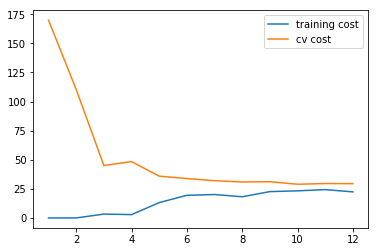

In [93]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

# 从学习曲线可以看出，欠拟合。随着数据量的增大，训练集代价值变化不大
# 肯定是训练集误差小于小于交叉验证集误差，因为是求的训练集代价小

In [94]:
# 改为多项式拟合，不是线性拟合。计算多项式值，再作为线性拟合
# 同时在多项式值前增加一列1
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).as_matrix()

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [95]:
# 返回多项式的值
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [96]:
X, y, Xval, yval, Xtest, ytest = load_data()
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


In [97]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [115]:
# 多项式回归数据
# 归一化，并在首列增加1列
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)

C:\Users\Administrator.XuanJi-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [116]:
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

In [121]:
# 绘制学习曲线
def plot_learning_curve(X, y, Xval, yval, lmbd):
    training_cost, cv_cost = [],[]
    m = X.shape[0]
    for i in range(1, m+1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], lmbd)
        
        # tc = regularized_cost(res.x, X[:i, :], y[:i], l = lmbd)
        # cv = regularized_cost(res.x, Xval, yval, l = lmbd)
        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

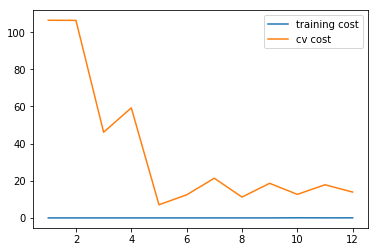

In [122]:
lmbd = 0
plot_learning_curve(X_poly, y, Xval_poly, yval, lmbd)
plt.show()
# 当lambd都为0时，训练集代价为0，过拟合

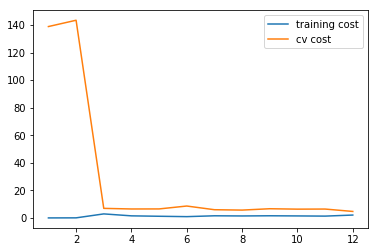

In [123]:
lmbd = 1
plot_learning_curve(X_poly, y, Xval_poly, yval, lmbd)
plt.show()

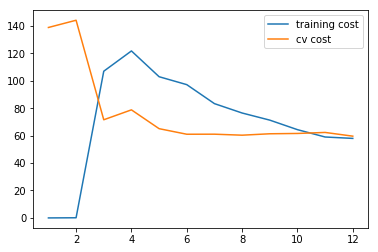

In [124]:
lmbd = 100
plot_learning_curve(X_poly, y, Xval_poly, yval, lmbd)
plt.show()

In [125]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

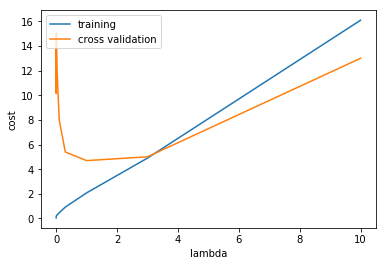

In [126]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [127]:
# 找出使交叉数据集代价最小的lambda
l_candidate[np.argmin(cv_cost)]

1

In [128]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 9.982275423899827
test cost(l=0.001) = 10.96403493885111
test cost(l=0.003) = 11.264458872657682
test cost(l=0.01) = 10.880094765571297
test cost(l=0.03) = 10.022266931655883
test cost(l=0.1) = 8.632063139750382
test cost(l=0.3) = 7.336640278544401
test cost(l=1) = 7.466289435179381
test cost(l=3) = 11.64393193727906
test cost(l=10) = 27.715080291767972
